# GAME-TEI 2020 Competition

## Introduction

This notebook contains the starter code for the GAME-TEI Capstone Assignment Competition. The notebook is broken down into different sections. The first 3 sections will walk you through a basic pipeline for creating and training a baseline classifier model. Our baseline uses a AlexNet, which is a basic [CNN architecture](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d). Section 4 will provide you with a helper function to produce your outputs in a .csv format to be submitted to the Kaggle competition. Section 5 will then provide you with some tips on possible improvements you can make.

## Task
In this competition, your task is to train a classifier to diagnose pneumonia using chest x-rays.

##  1. Setup
Download the dataset and extract. NOTE: Run this code cell only once if you are on the same instance!

In [1]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1zQxc_BGG6oZCwQzuhBgqGG9wcbrPZwKg' -O $(curl -s "https://drive.google.com/file/d/1zQxc_BGG6oZCwQzuhBgqGG9wcbrPZwKg/view?usp=sharing" | grep -o '<title>.*</title>' | cut -d'>' -f2 | awk -F ' - Goo' '{print $1}')
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/NORMAL/IM-0140-0001.jpeg  
  inflating: dataset/train/NORMAL/IM-0474-0001.jpeg  
  inflating: dataset/train/NORMAL/IM-0129-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-1224-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0926-0001.jpeg  
  inflating: dataset/train/NORMAL/IM-0545-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-1135-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-1059-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-1250-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0433-0001.jpeg  
  inflating: dataset/train/NORMAL/IM-0533-0001-0001.jpeg  
  inflating: dataset/train/NORMAL/IM-0650-0001-0002.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0790-0001.jpeg  
  inflating: dataset/train/NORMAL/IM-0243-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-1153-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0772-0001.jpeg  
  i

Import relevant modules

In [2]:
# import system modules
import os
import sys
import datetime
import random

# import external helpful libraries
import tensorflow as tf
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import imgaug as ia
import imgaug.augmenters as iaa

# import keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, TensorBoard

# possible libraries for metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

%load_ext tensorboard

Using TensorFlow backend.


In machine learning tasks, reproducibility of performance is extremely important to ensure the model performs as expected. Here, we set random seeds to help ensure reproducibility of results.

In [3]:
# Set the random seed to ensure reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)

## 2. Defining inputs and outputs
To feed our dataset into our training, we break the process into two parts. The first part will involve creating a list of tuples `(file_path, class_idx)`. The `file_path` variable will hold the path to the image to allow for easy accessing in part two. `class_idx` is 1 for pneumonia, and 0 for normal.

The second part involves creating a Keras data generator which is used for training on large data. The generator handles the feeding of batches of inputs/outputs for training. 

### 2.1 Part 1: Load dataset paths
Using the downloaded dataset, we load the file paths to the images into a list for easy access. 

If you moved your dataset, edit the path to your dataset accordingly. We also print the training and validation set split.

In [4]:
# Edit this variable to point to your dataset, if needed
dataset_path = "dataset"

def load_dataset(dataset_path, split="train"):
    '''
    Loads the dataset and returns a list of (img path, class) tuples.

    Inputs:
    - dataset_path (string): path to root of dataset
    - split (string): "train" (default), "val" or "test"

    Outputs:
    - data_out (list of tuples): a list of (img path, class) tuples
                                class is 0 for NORMAL, 1 for PNEUMONIA
    '''
    split_path = os.path.join(dataset_path, split)
    data_out = []
    
    # iterate each class
    classes = ["NORMAL", "PNEUMONIA"]
    # notice that class_idx = 0 for NORMAL, 1 for PNEUMONIA
    for class_idx, _class in enumerate(classes):
        class_path = os.path.join(split_path, _class) # path to each class dir
        # iterate through all files in dir
        for filename in os.listdir(class_path):
            # ensure files are images, if so append to output
            if filename.endswith(".jpeg"):
                img_path = os.path.join(class_path, filename)
                data_out.append((img_path, class_idx))
                
    return data_out

# load train and val splits
train_seq = load_dataset(dataset_path)
val_seq =  load_dataset(dataset_path, split="val")

# print split info
train_pneumonia_cases = sum([class_idx for (img_path, class_idx) in train_seq])   # compute pneumonia cases by summing the total number of 1's
train_normal_cases = len(train_seq) - train_pneumonia_cases                       # subtract from total to get normal cases
val_pneumonia_cases = sum([class_idx for (img_path, class_idx) in val_seq])
val_normal_cases = len(val_seq) - val_pneumonia_cases
print("Train split - Total: %d, Normal: %d, Pneumonia: %d" % (len(train_seq), train_normal_cases, train_pneumonia_cases))
print("Val split - Total: %d, Normal: %d, Pneumonia: %d" % (len(val_seq), val_normal_cases, val_pneumonia_cases))

Train split - Total: 5016, Normal: 1241, Pneumonia: 3775
Val split - Total: 216, Normal: 108, Pneumonia: 108


Using the file paths, we can easily access the images as needed. Here, we shall inspect the dataset by displaying five random images from each class. Notice that it's not always easy to differentiate the classes.

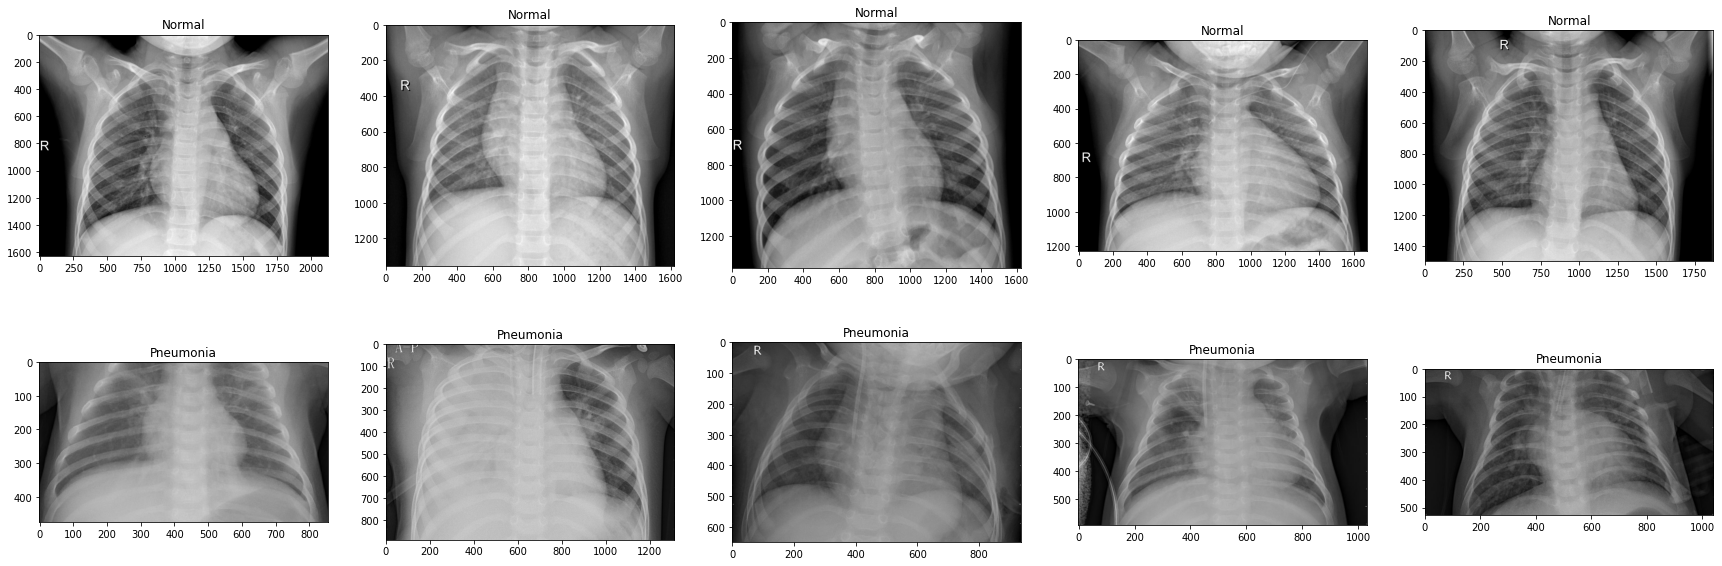

In [5]:
# Create a matplotlib plot of the images
fig, ax = plt.subplots(2, 5, figsize=(30,10))
for x in range(2):
    # set the boundaries for getting idx for NORMAL
    # since the images are loaded such that normal images
    # are loaded first, it always starts from index 0.
    # the ending index is computed based on the number of
    # training normal images
    if x == 0:
        low = 0
        high = train_normal_cases # high is exclusive
    # get the boundary indices for PNEUMONIA
    else:
        low = train_normal_cases
        high = len(train_seq)
    for y in range(5):
        # select a random image
        sample_idx = np.random.randint(low, high)
        # read the image
        sample = cv2.imread(train_seq[sample_idx][0])
        # display image
        ax[x, y].imshow(sample, cmap='gray')
        # set title of plots
        ax[x, y].set_title("Normal" if x == 0 else "Pneumonia")
plt.show()

### 2.2 Part 2: Creating the data generator
The data generator loads the images and labels in an easy manner to feed into the training pipeline. This is where you also make adjustments that would apply to all inputs, such as data augmentations.

In [6]:
class xray_data_generator(keras.utils.Sequence):
    """
    Data generator derived from Keras' Sequence to be used with fit_generator.
    """
    def __init__(self, seq, dims=(224,224), batch_size=32):
        # Save params into self
        self.dims = dims
        self.batch_size = batch_size
        self.seq = seq
        
        # create data augmentor
        # empty for baseline
        self.aug = iaa.OneOf([
                # iaa.Fliplr(), # horizontal flips
                # iaa.Affine(rotate=10), # rotations
                # iaa.Multiply((0.8, 1.2))  #random brightness
              ])

        # shuffle the dataset
        random.shuffle(self.seq)    

    def get_data(self, index):
        '''
        Given an index, retrieve the image and apply processing,
        including resizing and converting color encoding. This is
        where data augmentation can be added if desired.
        '''
        img_path, class_idx = self.seq[index]
        # Load the image
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.dims)

        # if grayscale, convert to RGB
        if img.shape[-1] == 1:
            img = np.stack((img,img,img), axis=-1)

        # by default, cv2 reads images in using BGR format
        # we want to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # normalize values to [0, 1]
        img = img.astype(np.float32)/255.

        # augment image
        img = self.aug.augment_image(img)

        # Load the labels
        label = keras.utils.to_categorical(class_idx, num_classes=2)
        
        return img, label

    def __len__(self):
        '''
        Returns the number of batches per epoch.
        Used by Keras' fit_generator to determine number of training steps.
        '''
        return int(np.floor(len(self.seq) / self.batch_size))

    def __getitem__(self, index):
        '''
        Actual retrieval of batch data during training.
        Data is retrieved by calling self.get_data on an index
        which is then batched, and returned
        '''
        # create empty batches
        batch_img = np.empty((self.batch_size,) + self.dims + (3,))
        batch_label = np.empty((self.batch_size,) + (2,))

        # load the images and labels into the batch
        # using the get_data method defined above
        for i in range(self.batch_size):
            img, label = self.get_data(index*self.batch_size+i)    
            batch_img[i] = img
            batch_label[i] = label

        return batch_img, batch_label

    def on_epoch_end(self):
        '''
        Shuffles the data sequence after each epoch
        '''
        random.shuffle(self.seq)

In [7]:
train_gen = xray_data_generator(train_seq)
val_gen = xray_data_generator(val_seq)

## 3. Training the model

### 3.1 Model definition
Here we define the model to be trained for our classification task. In our baseline, we are using a stripped down version of the AlexNet.

In [8]:
def baseline_model(input_shape):
    '''
    Returns a baseline model, which is a simpler AlexNet. 
    '''
    inpt = Input(shape=input_shape, name="input_img")
    # Convolutional layers
    # 1st conv layer
    x = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', name='conv1')(inpt)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='pool1')(x)
    x = BatchNormalization(name='bn1')(x)
    # 2nd conv layer
    x = Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation='relu', name='conv2')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='pool2')(x)
    x = BatchNormalization(name='bn2')(x)
    # 3rd conv layer
    x = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    # 4th conv layer omitted
    # 5th conv layer
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', name='conv5')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='pool3')(x)
    x = BatchNormalization(name='bn4')(x)
    
    # Dense layers
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.4, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.4, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=inpt, outputs=x, name='baseline')
    return model

In [9]:
# Size of inputs in (width, height, color channels)
# color channels is RGB, hence 3
input_shape = (224,224,3)

# Create the model using the defined function
model = baseline_model(input_shape)
model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 54, 54, 96)        34944     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 27, 27, 96)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 27, 27, 96)        384       
_________________________________________________________________
conv2 (Conv2D)               (None, 17, 17, 256)       2973952   
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 256)         0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 8, 8, 256)         102

### 3.2 Training parameters
Before executing the training, we will set up parameters to be used for our training. We also define the optimizer that our training will use. Lastly, we will setup callbacks.  These callbacks are set up to be called at the end of every epoch, to print and track some metrics. Using the metrics, we can perform early stopping and save our best model.

In [10]:
# Setup training parameters
learning_rate = 1e-4
epochs = 30
early_stop_patience = 7

# Define optimizer
# Here we are using the Adam optimizer which is usually a good starting point
optimizer = Adam(lr=learning_rate)
# optimizer = SGD(lr=learning_rate)   # SGD Optimizer

# Define metrics
# By default, we are using accuracy
# We can however, monitor other metrics during training
# AUC measures Area Under Curve
auc = tf.keras.metrics.AUC()

# Define callbacks for training
# Early stop allows us to stop the training when there is no perceived
# improvement anymore, based on the defined patience
# COMMENTED OUT FOR BASELINE MODEL, PROVIDED FOR YOUR EASE OF USE
# early_stop = EarlyStopping(monitor='val_loss',
#                            patience=early_stop_patience, 
#                            verbose=1, 
#                            mode='max')

# ModelCheckpoint saves the best model weight so far.
checkpt = ModelCheckpoint(monitor='val_loss',
                          filepath='best_model.h5', 
                          save_best_only=True)

# Set up tensorboard for logging
# setup logdir based on datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir)

# Compile the model based on our defined metrics and optimizer
model.compile(loss='binary_crossentropy', 
              metrics=['accuracy', 
                      #  auc    # COMMENTED OUT FOR BASELINE
                       ], 
              optimizer=optimizer)

###  3.3 Training
The below command executes the training. Observe that the training loss should be going down over time.

In [11]:
history = model.fit_generator(train_gen, 
                              epochs=epochs, 
                              verbose=1, 
                              validation_data=val_gen,
                              callbacks=[checkpt, 
                                        # early_stop,   # COMMENTED OUT FOR BASELINE
                                        tensorboard_callback
                                        ]
                              )

Epoch 1/30
156/156 [==============================] - 71s 457ms/step - loss: 0.2177 - accuracy: 0.9141 - val_loss: 2.2264 - val_accuracy: 0.5104
Epoch 2/30
156/156 [==============================] - 69s 443ms/step - loss: 0.1413 - accuracy: 0.9449 - val_loss: 2.6154 - val_accuracy: 0.5208
Epoch 3/30
156/156 [==============================] - 70s 446ms/step - loss: 0.1147 - accuracy: 0.9579 - val_loss: 0.2893 - val_accuracy: 0.9167
Epoch 4/30
156/156 [==============================] - 71s 453ms/step - loss: 0.0919 - accuracy: 0.9681 - val_loss: 0.2998 - val_accuracy: 0.9010
Epoch 5/30
156/156 [==============================] - 70s 449ms/step - loss: 0.0795 - accuracy: 0.9704 - val_loss: 0.4797 - val_accuracy: 0.7917
Epoch 6/30
156/156 [==============================] - 70s 450ms/step - loss: 0.0670 - accuracy: 0.9778 - val_loss: 5.8313 - val_accuracy: 0.5052
Epoch 7/30
156/156 [==============================] - 70s 449ms/step - loss: 0.0724 - accuracy: 0.9730 - val_loss: 1.6538 - val_ac

### 3.4 Plotting the training curves
It may be useful to analyze how the losses and metrics change during our training. Use the tensorboard command to examine the training curves for our model.

In [12]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

## 4. Produce Kaggle outputs
Note that your results so far are only representative on the train/val splits. It may differ a lot on the test set if your model overfitted! We will now produce the outputs to be submitted for the Kaggle competition, where you can see your test set performance. The code snippet will produce a .csv file. Submit it to the Kaggle page to see your results on the (public) leaderboard!

In [13]:
def output_test_csv(dataset_path, model, output_file="test.csv"):
    '''
    Makes predictions using the model from the test split. This produces an output
    .csv file to be submitted to the Kaggle platform to see your model performance 
    on the leaderboard.
    
    Inputs:
    - dataset_path (string): path to root of dataset
    - model (Keras model): model to be used for prediction
    - output_file (string): filename of output .csv file

    Outputs:
    - None
    '''
    # Define batch size
    batch_size = 32    
    # Get model input shape by accessing the layers of the model
    # e.g. (224,224,3)
    model_input_shape =  model.layers[0].input_shape[1:]
    # Obtain dimensions (width, height)
    # e.g. (224,224)
    dims = model_input_shape[:2]
    # Get path to the test split in the dataset
    test_folder_path = os.path.join(dataset_path, "test")
    
    # Evaluate the model in batches
    outs = np.array([])   # compile all the outputs
    # iterate through all files in test dir
    # sorting ensures that we have a standardised order of predictions
    # i.e. always give predictions in order: (0000.jpeg, 0001.jpeg,...)
    files = sorted(os.listdir(test_folder_path)) 
    # get only images
    image_filter_lambda = lambda x: x.endswith(".jpeg")   
    imgs = list(filter(image_filter_lambda, files))
    
    print("Making predictions...")
    num_imgs = len(imgs)
    # Get number of batches to compute
    num_batches = int(num_imgs / batch_size) + 1
    # tqdm gives us a progress bar
    for batch_idx in tqdm(range(num_batches), file=sys.stdout):
        # compute the start and end index for each batch
        start = batch_idx * batch_size
        if batch_idx == num_batches - 1 and (batch_idx + 1) * batch_size > num_imgs:
            end = num_imgs  # clip our end index to the number of images
        else:
            end = (batch_idx + 1) * batch_size
        
        # create empty batch
        batch_img = np.empty((end - start,) + model_input_shape)
        # load images into batch
        for i in range(end - start):
            img_path = os.path.join(test_folder_path, imgs[start+i])
            # Load the image
            img = cv2.imread(img_path)
            img = cv2.resize(img, dims)

            # if grayscale, convert to RGB
            if img.shape[-1] == 1:
                img = np.stack((img,img,img), axis=-1)

            # by default, cv2 reads images in using BGR format
            # we want to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # normalize values to [0, 1]
            img = img.astype(np.float32)/255.  
            batch_img[i] = img
          
        # Make predictions
        batch_out = model.predict(x=batch_img)
        # argmax gives us the class predicted from probabilities
        # e.g. probabilities (0.3, 0.7) -> class = 1 (PNEUMONIA) predicted
        batch_out = np.argmax(batch_out, axis=-1)
        outs = np.append(outs, batch_out)
    
    # convert into integers (0.0 -> 0, 1.0 -> 1)
    outs = outs.astype(int)

    # output predictions as .csv file
    output_df = pd.DataFrame(outs)
    output_df.columns = ['Prediction']
    output_df['Id'] = output_df.index
    output_df = output_df[['Id', 'Prediction']]
    output_df.to_csv(output_file, index=False)
    print("Output csv saved")

In [14]:
# Use the following line to load the best model 
# you have saved using ModelCheckpoint
# model = keras.models.load_model('best_model.h5')

# Call to output the csv
output_test_csv(dataset_path, model)

Making predictions...
100%|██████████| 20/20 [00:08<00:00,  2.34it/s]
Output csv saved


From here you can open the file directory, and download the csv file to your local machine. Then, upload to Kaggle to make your submission.

## 5. Possible improvements
If you have gone through the starter code in the notebook, you now have a functioning baseline model which gives a test accuracy of about 70%. Now, you should make changes and conduct your own explorations to improve the model and obtain the best possible results! This document will provide a short write-up to give you some ideas of the strategies you can attempt. We strongly encourage you to draw from what you have learned over the last few weeks, and discuss in the Slack different techniques to maximise your results.

### 5.1 Dealing with the imbalance
As you can see in Section 2.1, the dataset in fairly imbalanced in terms of classes. This is a fairly common problem in medical AI, since you will usually have more scans from sick patients as compared to healthy patients. Heavy data imbalance can generally lead to poor performing models. Hence, addressing this imbalance may be helpful in improving your model performance. [This article](https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2) briefly discusses the problem of imbalanced data and the approaches to dealing with it. [This guide from Tensorflow](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversample_the_minority_class) will provide a walkthrough with code using Keras on how to implement some of the approaches. 

#### 5.1.1 Data Augmentation
Data augmentation involves making changes to your input dataset that do not affect the class, but are feasible for the medical use case. Data augmentation allows you to artificially increase the size of your dataset. By augmenting the class with less samples, you are removing the imbalance. Even without data imbalance, data augmentation is usually a good idea to increase your data size, since deep learning is necessarily a data-hungry approach.

To implement data augmentation in this pipeline, there are libraries such [imgaug](https://imgaug.readthedocs.io/en/latest/) which will be helpful. Look into Section 2.2 under `get_data` of `xray_data_generator`, to work with data augmentation. Placeholder code has been provided there, without any transformations applied. In the cell before, we demonstrate the effects of using `imgaug` on the input images. For more code examples on using imgaug, look [here](https://imgaug.readthedocs.io/en/latest/source/examples_basics.html).

Note that when doing augmentations, it should not make it difficult to determine the output class from the augmented image. For example, translating more than half of the image off-screen, may cause important details to be hidden.

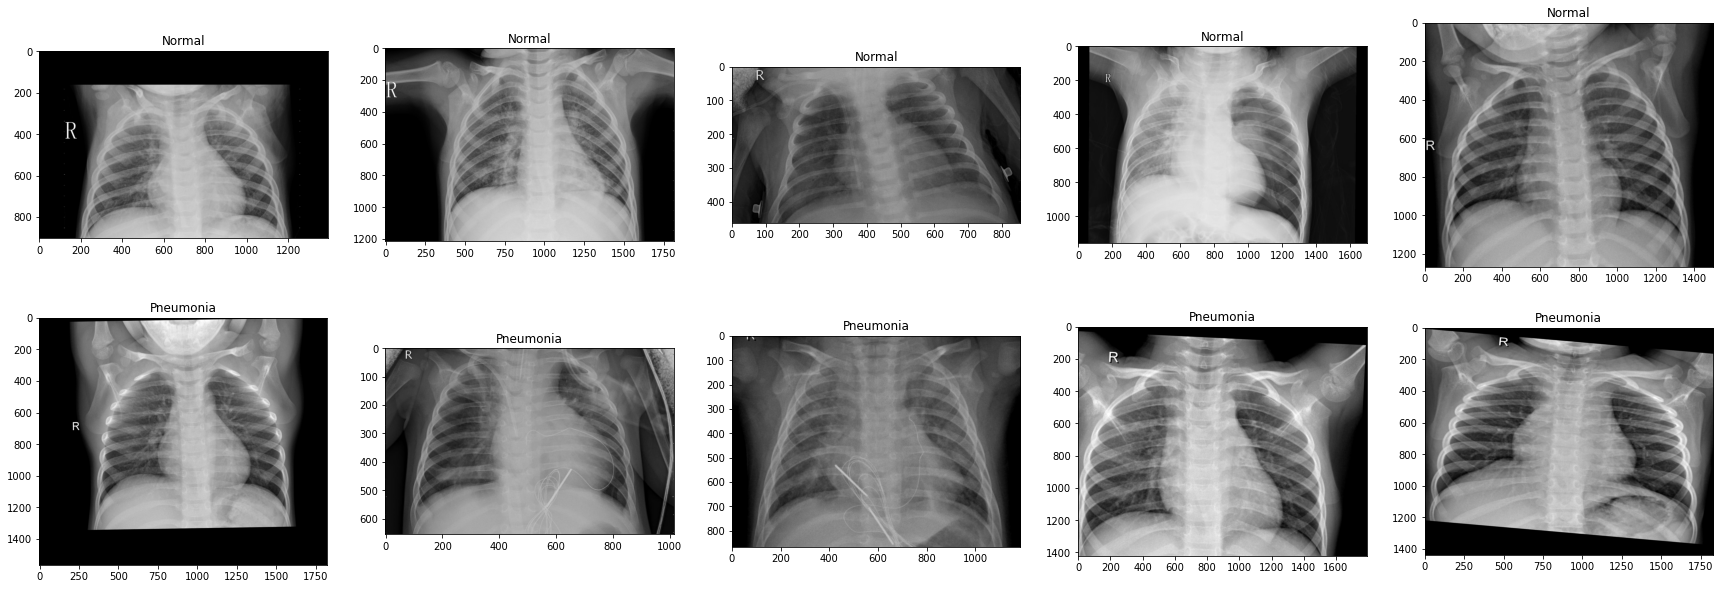

In [15]:
# Create data augmentor
# Some random parameters
aug = iaa.OneOf([
                iaa.Fliplr(), # horizontal flips
                iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},     # scaling images
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},   # translate images
                    rotate=(-5, 5) # rotate images
                ),
                iaa.Multiply((0.8, 1.2))  #random brightness
              ])

# Create a matplotlib plot of the images
fig, ax = plt.subplots(2, 5, figsize=(30,10))
for x in range(2):
    # set the boundaries for getting idx for NORMAL
    # since the images are loaded such that normal images
    # are loaded first, it always starts from index 0.
    # the ending index is computed based on the number of
    # training normal images
    if x == 0:
        low = 0
        high = train_normal_cases # high is exclusive
    # get the boundary indices for PNEUMONIA
    else:
        low = train_normal_cases
        high = len(train_seq)
    for y in range(5):
        # select a random image
        sample_idx = np.random.randint(low, high)
        # read the image
        sample = cv2.imread(train_seq[sample_idx][0])
        ######## AUGMENT THE IMAGE ############
        sample = aug.augment_image(sample)
        #######################################
        # display image
        ax[x, y].imshow(sample, cmap='gray')
        # set title of plots
        ax[x, y].set_title("Normal" if x == 0 else "Pneumonia")
plt.show()

#### 5.1.2 Class weights and oversampling
Other methods of dealing with imbalance involves changing the class weights and oversampling. [The article from Tensorflow](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) gives a good walkthrough with code on these methods. Note that class weights were utilised in Lab 1 with the credit card fraud dataset (so you have a great example available).

Implementing class weights will go into Section 3.2/3.3 and oversampling will involve dealing with Section 2.1/2.2.

### 5.2 Tweaking hyperparameters
An important part of deep learning involves tweaking the hyperparameters. This can involve any part of the pipeline, such as model input shape, number of filters, number of layers, learning rate, batch size, etc. It may also be worthwhile to find and explore more advanced optimizers than Adam!

### 5.3 Improving the model
The most significant change will probably involve changing the model itself. As mentioned, the baseline model is a simple AlexNet which is a fairly dated architecture. Other noteworthy convolutional networks are for example, ResNet, InceptionNet, DenseNets and so on. Changes involving the model go into Section 3.1. There are many Keras code examples to be found online!

### 5.4 Transfer learning
Another approach you can take is to apply transfer learning. This means that using a model trained on another dataset (commonly ImageNet), we load the trained weights into our model. Then, we typically fine-tune the model using our own dataset for our task. 

The idea is that the original network has a better ability to capture information from input images since it was trained on the larger ImageNet. So, we 'transfer' this ability to our own model. When fine-tuning, we usually freeze the first few convolutional layers, which typically represents the model's ability to extract key features, such as lines and shapes. The number of layers to freeze depends on the size of the dataset. Typically, for smaller datasets, we only leave the `Dense` layers unfrozen and train on them. The larger the dataset, the more layers of the model you would leave unfrozen and train. 

An example of loading the weights, and freezing layers can be seen below. Other pre-trained models can be found online easily. Even newer, research models usually come with pre-trained weights too. Make sure to run `model.compile` again after loading weights and freezing layers.

In [16]:
# download pre-trained AlexNet
# courtesy of heuritech, from https://github.com/heuritech/convnets-keras#get-the-weights-of-the-pre-trained-networks
!wget http://files.heuritech.com/weights/alexnet_weights.h5

# load weights file
f = h5py.File('alexnet_weights.h5', 'r')

# use print statement to view the keys of the weights
# this gives us the name of the layer in the model
# print(list(f.keys()))

# Load the weights and bias
W, b = f['conv_1']['conv_1_W'], f['conv_1']['conv_1_b']
model.layers[1].set_weights = W,b

# freeze the layer
model.layers[1].trainable = False

--2020-06-21 16:37:53--  http://files.heuritech.com/weights/alexnet_weights.h5
Resolving files.heuritech.com (files.heuritech.com)... 188.165.215.225
Connecting to files.heuritech.com (files.heuritech.com)|188.165.215.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243904576 (233M)
Saving to: ‘alexnet_weights.h5’

alexnet_weights.h5  100%[===================>] 232.61M  12.0MB/s    in 21s     

2020-06-21 16:38:14 (11.1 MB/s) - ‘alexnet_weights.h5’ saved [243904576/243904576]



These are just some preliminary ideas to get you started. A successful model will usually involve a combination of multiple strategies. Another helpful hint would be to check out the original dataset on [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). Look into the [kernels](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/kernels) for inspiration!

# Happy Learning!